# How does mask-use rate impact on the chance of getting Covid in US?

Each states are enforcing different face-covering policy and people also have different opinion on wearing mask to prevent COVID. New York Times published a report based on roughly 250,000 interviews conducted by Dynata from July 2 to July 14 in 2020, and the report estimates the percents of people in county-level that never/rarely/sometimes/frequently/always use face-covering in public. Does the mask-use rate actually impact the chance of people getting COVID? How does the mask-use rate affect the growth rate of COVID cases on each state based on it's population density?

I will be analyzing the increase rate of confirmed COVID cases in each state based the state's mask-use to find out if wearing fask-covering has a linear relationship with the COVID increase rate. I would assume when a state uses mask more, the increase rate of COVID cases should be slower compare to other states with lower mask use rate. I will also look more into this analysis for states that have different population density separatly, and see how does the mask use rate impact COVID increase rate when a state is more populated.

Let's start the analysis with download the neccesary libraries and packages we will be using.

In [1]:
import numpy as np 
import pandas as pd 
import scipy as sp
import matplotlib.pyplot as plt # plot
from sklearn import linear_model # linear regression
import statsmodels.api as sm
from seaborn import heatmap

### 1. Data downloading

We will be using three datasets in total. The first two COVID-related datasets come from the Github website: https://github.com/nytimes/covid-19-data/tree/bde13b021e99c6b4a63fb66a6144e889cc635e31. The first dataset is the daily report of the cummulative confirmed cases for each state of 2020. Now let's save the csv file to a dataframe name "confirmed_df". This dataframe inlcudes the reported date, state's name, state's FIPS code, and number of cummulative confirmed cases reported on the day for each state. Let's print the head of "confirmed_df" for a quick look.

In [2]:
confirmed_df=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv')
display(confirmed_df.head(5))

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


The second dataset is the estimated mask-use rate in each county provided by the New York Times and Dynata. Let's download the csv file to a dataframe name "mask_use". This dataset should includes the county's 5-digit FIPS code, and estimated percents of people who Never/ Rarely/ Sometimes/ Frequently/ Always use face-covering in each county. Let's also print the head of "mask_use" for a quick look.

In [3]:
mask_use=pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv')
mask_use.head(5)

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


The last dataset is the population density by stated  from the link:  https://github.com/camillol/cs424p3/blob/master/data/Population-Density%20By%20State.csv. Let's download the csv file to a dataframe name "population_density" and print the head of the dataframe for a look.

In [4]:
density_df=pd.read_csv('https://raw.githubusercontent.com/camillol/cs424p3/master/data/Population-Density%20By%20State.csv')
display(density_df.head(5))

,GEO.id,GEO.id2,GEO.display-label,Density per square mile of land area
0,0400000US01,1,Alabama,94.4
1,0400000US02,2,Alaska,1.2
2,0400000US04,4,Arizona,56.3
3,0400000US05,5,Arkansas,56.0
4,0400000US06,6,California,239.1


### 2. Data cleaning and preprocessing

Now we have download the data to use in this analysis, and let's start with data cleaning and preprocessing. First, let's check if there is any missing or empty cell for all three dataframes.

In [5]:
c=confirmed_df.isnull().values.any()
m=mask_use.isnull().values.any()
d=density_df.isnull().values.any()
print(c,m,d)

False False False


We have confirmed there is no empty cells in all three dataframes and they are ready to use.


#### Part I. Confirmed_df

Now let's start with some data preparation for our first dataset "confirmed_df". Because the survey was taken place in July 2020 and the mask mandatory policy can change afterwards which makes the estimation be very different, we only want to focus on a relatively short range of time period so we can assume the maks_use rate is constant. We will filter the data from May to July 2020, and we will run analysis on each month of May, June and July, and their average to avoid bias. Because the number of confirmed cases are cummulative, and we are interested in seeing the monthly increase rate, which is the number of newly cases compare to the number in the beginning of the month, per each state.

Let's start with May, we will create a new column to record the number of confirmed cases of each state in the beginning of the month as "May_begin" and in last date of the month as "May_end". Then we will calculate the May increase rate by divide the increase number (May_end - May_begin) by "May_begin", and save as "May_increase_rate". For better clarificaiton, we will also have "May_increase_percent" column showing the increase rate in percentage.\
\
May Increase rate= (# cases at May end - # cases at May begin) / # cases at May begin 

In [6]:
May_begin=confirmed_df[confirmed_df['date']=='2020-05-01'].rename(columns={'cases':'May_begin'})
May_end=confirmed_df[confirmed_df['date']=='2020-05-31'].rename(columns={'cases':'May_end'})
May_df=May_begin.merge(May_end,on=['state'])
May_df['May_increase_rate']=(May_df['May_end']-May_df['May_begin'])/May_df['May_begin']
May_df['May_increase_percent'] = pd.Series(["{0:.2%}".format(val) for val in May_df['May_increase_rate']],index = May_df.index)
May_df['May_increase_percent'] = pd.Series(["{0:.2%}".format(val) for val in May_df['May_increase_rate']],index = May_df.index)

May_df=May_df[['state','May_begin','May_end','May_increase_rate','May_increase_percent']].sort_values(by='May_increase_rate', ascending=False)
May_df.head(3)

,state,May_begin,May_end,May_increase_rate,May_increase_percent
24,Minnesota,5730,24860,3.338569,333.86%
28,Nebraska,4838,14101,1.914634,191.46%
50,Virginia,16901,44607,1.639311,163.93%


In [7]:
state_count=len(May_df['state'])
print('The data has a total of ' + str(state_count) + ' states.')

The data has a total of 55 states.


Let's observe the increase rate in May for each state with a histogram to see the distribution.

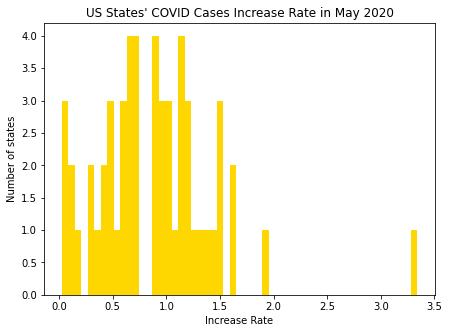

In [8]:
plt.figure(figsize=(7,5))
plt.hist(May_df['May_increase_rate'],bins=state_count,color='gold')
plt.title("US States' COVID Cases Increase Rate in May 2020")
plt.xlabel('Increase Rate')
plt.ylabel('Number of states')
plt.show()

We can see the May histogram look a little right skewed, the peak increase rate is around 0.7 to 1.2, and the majority of the increase rate for all states is between 0 to 1.5. Now let's do the same to observe the increase rate in June.

In [9]:
June_begin=confirmed_df[confirmed_df['date']=='2020-06-01'].rename(columns={'cases':'June_begin'})
June_end=confirmed_df[confirmed_df['date']=='2020-06-30'].rename(columns={'cases':'June_end'})
June_df=June_begin.merge(June_end,on=['state'])
June_df['June_increase_rate']=(June_df['June_end']-June_df['June_begin'])/June_df['June_begin']
June_df['June_increase_percent'] = pd.Series(["{0:.2%}".format(val) for val in June_df['June_increase_rate']],index = June_df.index)
June_df=June_df[['state','June_begin','June_end','June_increase_rate','June_increase_percent']].sort_values(by='June_increase_rate', ascending=False)
June_df.head(3)

,state,June_begin,June_end,June_increase_rate,June_increase_percent
2,Arizona,20123,79399,2.945684,294.57%
43,South Carolina,12148,36399,1.996296,199.63%
3,Arkansas,7443,20777,1.791482,179.15%


Let's plot a histogram to visualize the increase rate of June, 2020.

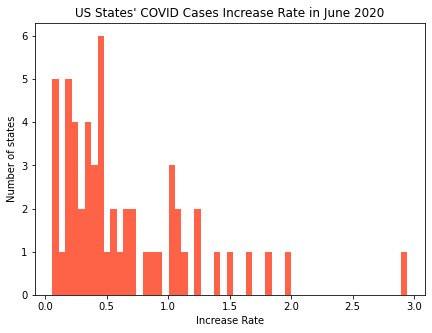

In [10]:
plt.figure(figsize=(7,5))
plt.hist(June_df['June_increase_rate'],bins=state_count,color='tomato')
plt.title("US States' COVID Cases Increase Rate in June 2020")
plt.xlabel('Increase Rate')
plt.ylabel('Number of states')
plt.show()

June's data looks more right skewed than May, and the peak increase rate is now 0.5, the overall increase rate shifted to left since May, meaning the overall increase rate has been decreasing.

In [11]:
July_begin=confirmed_df[confirmed_df['date']=='2020-07-01'].rename(columns={'cases':'July_begin'})
July_end=confirmed_df[confirmed_df['date']=='2020-07-31'].rename(columns={'cases':'July_end'})
July_df=July_begin.merge(July_end,on=['state'])
July_df['July_increase_rate']=(July_df['July_end']-July_df['July_begin'])/July_df['July_begin']
July_df['July_increase_percent'] = pd.Series(["{0:.2%}".format(val) for val in July_df['July_increase_rate']],index = July_df.index)
July_df=July_df[['state','July_begin','July_end','July_increase_rate','July_increase_percent']].sort_values(by='July_increase_rate', ascending=False)
July_df.head(3)


,state,July_begin,July_end,July_increase_rate,July_increase_percent
49,Virgin Islands,92,406,3.413043,341.30%
27,Montana,1016,3977,2.914370,291.44%
13,Idaho,6379,20853,2.269008,226.90%


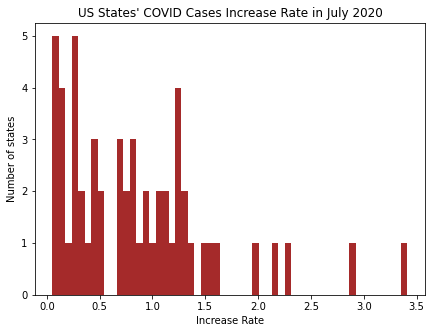

In [12]:
plt.figure(figsize=(7,5))
plt.hist(July_df['July_increase_rate'],bins=state_count,color='brown')
plt.title("US States' COVID Cases Increase Rate in July 2020")
plt.xlabel('Increase Rate')
plt.ylabel('Number of states')
plt.show()

The peak increase rate decreased to around 0.25 now, but the overall increase rate increased since June.

Let's put all three months in the same graph to check if we can see any obvisou pattern.

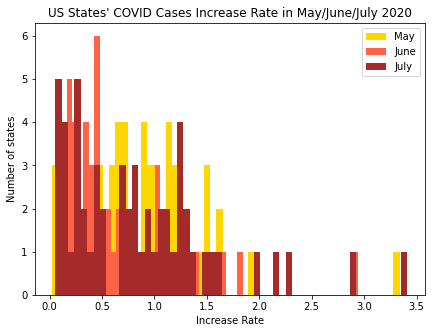

In [13]:
plt.figure(figsize=(7,5))
plt.hist(May_df['May_increase_rate'],bins=state_count,color='gold')
plt.hist(June_df['June_increase_rate'],bins=state_count,color='tomato')
plt.hist(July_df['July_increase_rate'],bins=state_count,color='brown')
plt.title("US States' COVID Cases Increase Rate in May/June/July 2020")
plt.xlabel('Increase Rate')
plt.ylabel('Number of states')
plt.gca().legend(['May','June','July'])
plt.show()

From plotting three months together, we observed the peak increase rate have been decreasing over time, but the overall rate went down a little bit from May to June, then increase from June to July. We have observed no significant trend over these three-month interval, so let's also use the average increase rate for three months to eliminate prediction errors.

Let's create a new dataframe called "merge_df" by merging the three dataframes, then calculate the "total_increase_rate" and "total_increase_percent" for over three months, and sort by the average increase rate. Let's print the head of this table.

Avg Increase rate= (# cases at July end - # cases at May begin) / # cases at May begin 

In [14]:
merge_df=May_df.merge(June_df,on='state').merge(July_df,on='state')
merge_df['total_increase_rate']=(merge_df['July_end']-merge_df['May_begin'])/merge_df['May_begin']
merge_df['total_increase_percent']=pd.Series(["{0:.2%}".format(val) for val in merge_df['total_increase_rate']],index = merge_df.index)
merge_df=merge_df.sort_values(by='total_increase_rate', ascending=False)
merge_df.head(3)


,state,May_begin,May_end,May_increase_rate,May_increase_percent,June_begin,June_end,June_increase_rate,June_increase_percent,July_begin,July_end,July_increase_rate,July_increase_percent,total_increase_rate,total_increase_percent
5,Arizona,7962,19936,1.503893,150.39%,20123,79399,2.945684,294.57%,84152,174108,1.068970,106.90%,20.867370,2086.74%
17,Texas,30342,64974,1.141388,114.14%,66081,166703,1.522707,152.27%,174826,443090,1.534463,153.45%,13.603190,1360.32%
25,South Carolina,6258,11861,0.895334,89.53%,12148,36399,1.996296,199.63%,37919,89016,1.347530,134.75%,13.224353,1322.44%


Then let's save only the states and our four increase rates into a new dataframe "increase_rate_df". Let's print the top five states with highest avg increase rate. 

In [15]:
increase_rate_df=merge_df[['state','May_increase_rate','June_increase_rate','July_increase_rate','total_increase_rate']]
increase_rate_df=increase_rate_df.sort_values(by='total_increase_rate', ascending=False)
#increase_percent_df=merge_df[['state','May_increase_percent','June_increase_percent','July_increase_percent','avg_increase_percent']]
increase_rate_df.head(5)

,state,May_increase_rate,June_increase_rate,July_increase_rate,total_increase_rate
5,Arizona,1.503893,2.945684,1.068970,20.867370
17,Texas,1.141388,1.522707,1.534463,13.603190
25,South Carolina,0.895334,1.996296,1.347530,13.224353
37,Florida,0.617368,1.682517,1.958557,12.547753
11,Arkansas,1.191239,1.791482,1.005520,11.843202


As shown above, Arizona has the highest COVID case increase rate from May to July 2020, which means the number of confirmed cases in July increased around 21 times since May. And followed by Florida, Alaska, Montana, and South Carolina.

Now let's observe the histogram of the distribution of the average increase rate for all states.

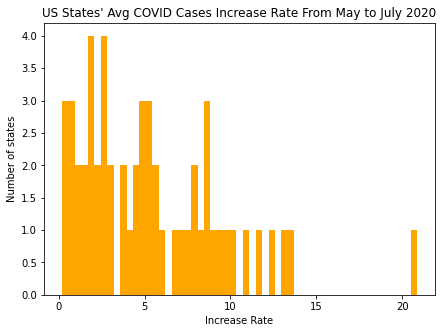

In [16]:
plt.figure(figsize=(7,5))
plt.hist(merge_df['total_increase_rate'],bins=state_count,color='orange')
plt.title("US States' Avg COVID Cases Increase Rate From May to July 2020")
plt.xlabel('Increase Rate')
plt.ylabel('Number of states')
plt.show()

The total three-month-interval increase rate is also very right skewed, the peak increase rate is at 2, which means the most states have increased their COVID confirm cases about 200% in three months. The majority of increase rate are within 1-10 times. 

#### Part II. State_FIPS 

Because we may use the state and it's FIPS code later, let's save a copy of each state and their corresponding state FIPS code and store in a dataframe "state_FIPS". We also run "drop_dupilicates" function to make sure we get unique value of states' FIPS code. We noticed the state's FIPS code not always in 2 digits, so we should also format the states' FIPS code to 2 digits, then print a head of this new dataframe we created.

In [17]:
state_FIPS=confirmed_df[['state','fips']].drop_duplicates()
state_FIPS['fips']=state_FIPS['fips'].astype(str).str.zfill(2)
display(state_FIPS[:5])

,state,fips
0,Washington,53
3,Illinois,17
5,California,06
8,Arizona,04
35,Massachusetts,25


#### Part III. Mask_use 

Now let's preprocessing the third dataframe, "mask_use". Because the data has 5 categorical value (Never, Rarely, Sometimes, Frequently, Always), we will calculate a "mask_use_score" value for each county by applying categorical value where Never=0, Rarely=1, Sometimes=2, Frequently=3, Always=4, and multiply each category with their percentage and sum all together. Lastly, add a new column "mask_use_rank" to rank the mask use score for each county from highest=1 (use the most mask).

mask_use_score= NEVER * 0 + RARELY * 1 + SOMETIMES * 2 + FREQUENTLY * 3 + ALWAYS * 4

In [18]:
mask_use['mask_use_score']=mask_use['NEVER']*0 + mask_use['RARELY']*1 + mask_use['SOMETIMES']*2+\
                           mask_use['FREQUENTLY']*3 + mask_use['ALWAYS']*4
mask_use=mask_use.sort_values(by='mask_use_score',ascending=False)
display(mask_use[:3])

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_use_score
1889,36123,0.000,0.006,0.023,0.087,0.884,3.849
202,6033,0.003,0.004,0.007,0.136,0.849,3.822
2627,48209,0.000,0.007,0.022,0.115,0.855,3.816


Let's observe the mask_use_score.

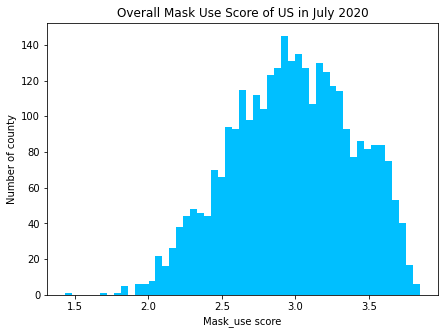

In [19]:
plt.figure(figsize=(7,5))
plt.hist(mask_use['mask_use_score'],bins=51,color='deepskyblue')
plt.title("Overall Mask Use Score of US in July 2020")
plt.xlabel('Mask_use score')
plt.ylabel('Number of county')
plt.show()

This is a good histogram, and we can see the majority is with 2.5 to 3.5, most states with mask use score of 3 which means people usually wear fask covering. 

The data is given by county-level and we are only insterested in the state-level, so we have to find out which state does each county belongs to in this dataframe. Since the county's FIPS code not always in 5 digits, so we want to first format the county' FIPS code to 5 digits then extract the first 2 digits where it represent the belonging state, and save as "state_fips" column. Let's print a sample row to visualize the data.

In [20]:
mask_use['COUNTYFP']=mask_use['COUNTYFP'].astype(str).str.zfill(5)
mask_use['state_fips']=mask_use['COUNTYFP'].astype(str).str[:2]
display(mask_use[:1])

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_use_score,state_fips
1889,36123,0.0,0.006,0.023,0.087,0.884,3.849,36


Then we want to groupy by each states and save the average of the county's mask use score of the state as the state's mask use socre. Let's print a sample row to visualize the data.

In [21]:
mask_use=mask_use.groupby(by='state_fips', as_index=False).mean()
display(mask_use[:1])

,state_fips,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,mask_use_score
0,01,0.081567,0.08109,0.146612,0.215343,0.475313,2.921597


Now let's re-organize the dataframe and add the name of each state by it's state_fips code. Let's only keep the state name and mask_use_score in a new dataframe "mask_df", and sort the result in in descending order of mask_use_score. Let's print the first 5 rows to see the states with wear the most mask according to the survey's estimation.

In [22]:
mask_use=mask_use.merge(state_FIPS,left_on='state_fips', right_on='fips')
mask_df=mask_use[['state','mask_use_score']].sort_values(by='mask_use_score',ascending=False)
mask_df.head(5)

,state,mask_use_score
39,Rhode Island,3.705600
11,Hawaii,3.695400
7,Delaware,3.685667
21,Massachusetts,3.674643
6,Connecticut,3.627375


The five states have highest mask-use score, or use the most mask are Rhode Island, Hawaii, Delaware, Massachusetts and Connecticut. Now let's observe the mask_use_score data per each state.

In [23]:
mask_df['mask_use_score'].describe()

count    51.000000
mean      3.090158
std       0.387781
min       2.240283
25%       2.817213
50%       3.076552
75%       3.358323
max       3.705600
Name: mask_use_score, dtype: float64

Observed there are 51 lines of the data, so we have survey for mask use rate of 51 states, maximum is 3.71, minimum is 2.24, and average is 3.09.

#### Part IV. Density_df

For the population density by state's data, let's first rename the columns to more clear terms, then only leave the state name and it's population density in the dataframe, and sort by the density in descending order.

In [24]:
density_df=density_df.rename(columns={'GEO.display-label':'state','Density per square mile of land area':'population_density'})
density_df=density_df[['state','population_density']].sort_values(by='population_density',ascending=False)
density_df.head(5)

,state,population_density
8,District of Columbia,9856.5
30,New Jersey,1195.5
51,Puerto Rico,1088.2
39,Rhode Island,1018.1
21,Massachusetts,839.4


We have observed the population density data, and found that the District of Columbia has a lot more density than the rest, so this could be an outlier data point. Let's update the dataframe without this outlier datapoint, then observe the some properties of this dataset. Lastly, we will create a box plot for visualization.

In [25]:
density_df=density_df[density_df['state'] != 'District of Columbia']
density_df.describe()

,population_density
count,51.000000
mean,212.476471
std,287.141026
min,1.200000
25%,45.800000
50%,101.200000
75%,221.450000
max,1195.500000


Text(0.5, 1.0, "Box plot of US States' population density")

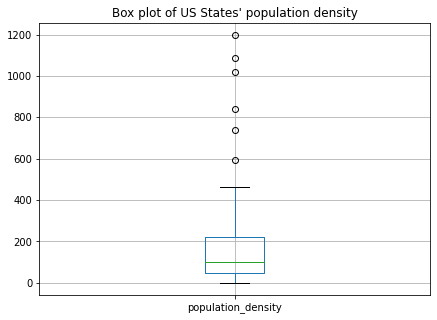

In [26]:
fig=density_df.boxplot(column=['population_density'],figsize=(7,5))
fig.set_title("Box plot of US States' population density")

We have saved the lower and upper quantile density number as 45 and 221 from the property shown above. We will consider a state with a lower than 45 population density as "low_density_state", and a higher than 221 population density as "high_density_state". 

#### Part V. Total_df

The last step for data preprocessing is to combine the increase_rate_df, mask_df, and density_df to one df called "total_df".

In [27]:
total_df=mask_df.merge(increase_rate_df,on='state').merge(density_df,on='state').sort_values(by='total_increase_rate',ascending=False)
low_density_states=total_df[total_df['population_density']<=45]
high_density_states=total_df[total_df['population_density']>=221]
total_df.head(5)

,state,mask_use_score,May_increase_rate,June_increase_rate,July_increase_rate,total_increase_rate,population_density
15,Arizona,3.304533,1.503893,2.945684,1.068970,20.867370,56.3
20,Texas,3.230295,1.141388,1.522707,1.534463,13.603190,96.3
28,South Carolina,2.991196,0.895334,1.996296,1.347530,13.224353,153.9
22,Florida,3.191313,0.617368,1.682517,1.958557,12.547753,350.6
33,Arkansas,2.877320,1.191239,1.791482,1.005520,11.843202,56.0


We have completed data cleaning and preprocessing, and let's move on to analysis now.

### 2. Data analysis and visualization

#### Part I. Mask use score vs Covid increase rate from May to July

We want to analyze if there is any linear relationship between mask use rate/score and COVID cases increase rate, because using one month's dataset could be not as acurate, we will run the linear regression model with one indepdent variable: mask_use_score, and four dependent variables: May's rate, June's rate, July's rate, total rate. My hypothesis would be an obvious negative relationship -- wear a mask could definitly decrease the chance of getting COVID.

Let's first observe the scatter plots of mask_use_score versus the increase rate in May, then run a least square regression model (ols) to check our prediction.

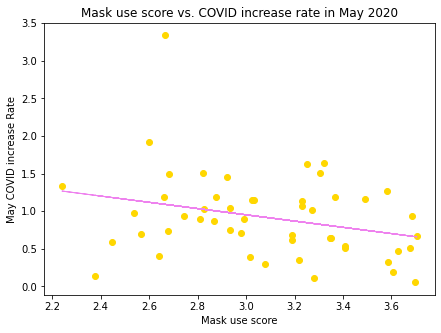

In [28]:
x=total_df['mask_use_score']
y1=total_df['May_increase_rate']
# Plot the regression line
m1, b1 = np.polyfit(x, y1, 1)  #m = slope, b=intercept
plt.figure(figsize=(7,5))
plt.plot(x, m1*x+b1, color='violet',linewidth=1)
# Plot the data points
plt.scatter(x,y1,color='gold')

plt.title("Mask use score vs. COVID increase rate in May 2020")
plt.ylabel('May COVID increase Rate')
plt.xlabel('Mask use score')

plt.show()

In [29]:
x1=sm.add_constant(x)
model = sm.OLS(y1,x1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      May_increase_rate   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.244
Date:                Fri, 10 Dec 2021   Prob (F-statistic):             0.0448
Time:                        07:18:11   Log-Likelihood:                -39.419
No. Observations:                  50   AIC:                             82.84
Df Residuals:                      48   BIC:                             86.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.2000      0.627      3.

/usr/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


We have observed our regression line has a decreasing slope, which means mask_use_score has a negative correlation - the more mask your are wearing, the slower COVID cases increase rate is. However, our R-square (0.081) is very small which indicates there is no strong relationship between our independent and dependent variable. Our standard error(0.202) is relatively large, and P value (0.045) which indicated the fit is not very good.\
\
Let's move to June to see if there is any better fit.

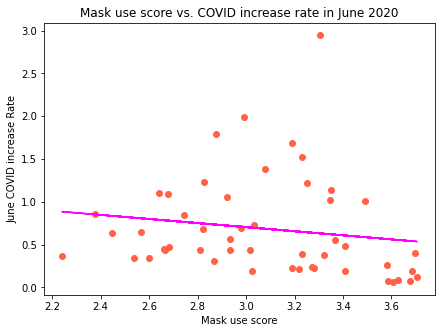

In [30]:
y2=total_df['June_increase_rate']
m2, b2 = np.polyfit(x, y2, 1)  #m = slope, b=intercept
plt.figure(figsize=(7,5))
plt.plot(x, m2*x+b2, color='magenta')
plt.scatter(total_df[['mask_use_score']],total_df[['June_increase_rate']],color='tomato')
plt.title("Mask use score vs. COVID increase rate in June 2020")
plt.ylabel('June COVID increase Rate')
plt.xlabel('Mask use score')
plt.show()


In [31]:
model = sm.OLS(y2,x1)
fit=model.fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:     June_increase_rate   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.228
Date:                Fri, 10 Dec 2021   Prob (F-statistic):              0.273
Time:                        07:18:11   Log-Likelihood:                -42.574
No. Observations:                  50   AIC:                             89.15
Df Residuals:                      48   BIC:                             92.97
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.4188      0.667      2.

The correlation between the mask score and June's increase rate is also not very strong, the R-square value is 0.025, standard error is 0.215, and P value is 0.273, which are even worse than the prediction in May. Now let's observe July's data.

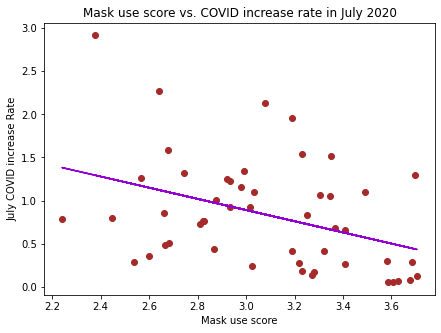

In [32]:
y3=total_df['July_increase_rate']
m3, b3 = np.polyfit(x, y3, 1)  #m = slope, b=intercept
plt.figure(figsize=(7,5))
plt.plot(x, m3*x+b3, color='darkviolet')
plt.scatter(total_df[['mask_use_score']],total_df[['July_increase_rate']],color='brown')
plt.title("Mask use score vs. COVID increase rate in July 2020")
plt.ylabel('July COVID increase Rate')
plt.xlabel('Mask use score')
plt.show()

In [33]:
model = sm.OLS(y3,x1).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     July_increase_rate   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     8.796
Date:                Fri, 10 Dec 2021   Prob (F-statistic):            0.00469
Time:                        07:18:11   Log-Likelihood:                -43.319
No. Observations:                  50   AIC:                             90.64
Df Residuals:                      48   BIC:                             94.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.8336      0.677      4.

We have see a stronger negative correlation in July, the R-square value is 0.155, p value is 0.005, and standard error is 0.218. This indiciates we are more confident to say that use mask can decrease the COVID increase rate by 0.64 (64%).
\
Now, let's observe three graphs together.

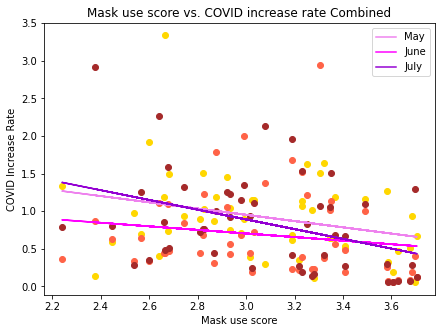

In [34]:
plt.figure(figsize=(7,5))
#May plot
plt.scatter(total_df[['mask_use_score']],total_df[['May_increase_rate']],color='gold')
plt.plot(x, m1*x+b1, color='violet')
#June plot
plt.scatter(total_df[['mask_use_score']],total_df[['June_increase_rate']],color='tomato')
plt.plot(x, m2*x+b2, color='magenta')
#July plot
plt.scatter(total_df[['mask_use_score']],total_df[['July_increase_rate']],color='brown')
plt.plot(x, m3*x+b3, color='darkviolet')

plt.title("Mask use score vs. COVID increase rate Combined")
plt.ylabel('COVID Increase Rate')
plt.xlabel('Mask use score')
plt.gca().legend(['May','June','July'])
plt.show()

Even though there is not an obvious trend, we could see all three months have shown a pattern of higher mask use score, the less COVID increase rate there is. June's data could be affected by some other reasons, but July shows a more negative correlation than previous months.

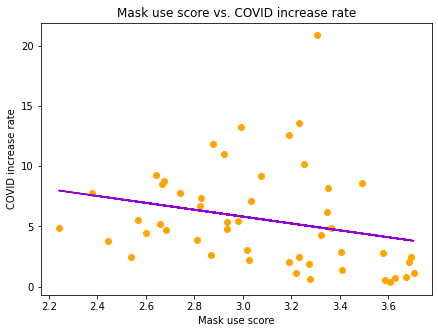

In [35]:
plt.figure(figsize=(7,5))
x=total_df['mask_use_score']
y=total_df['total_increase_rate']
m, b = np.polyfit(x, y, 1)  #m = slope, b=intercept
plt.plot(x, m*x+b, color='darkviolet')
plt.scatter(total_df[['mask_use_score']],total_df[['total_increase_rate']],color='orange')
plt.title("Mask use score vs. COVID increase rate")
plt.ylabel('COVID increase rate')
plt.xlabel('Mask use score')
plt.show()

In [36]:
model = sm.OLS(y,x1).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     total_increase_rate   R-squared:                       0.067
Model:                             OLS   Adj. R-squared:                  0.048
Method:                  Least Squares   F-statistic:                     3.460
Date:                 Fri, 10 Dec 2021   Prob (F-statistic):             0.0690
Time:                         07:18:12   Log-Likelihood:                -140.80
No. Observations:                   50   AIC:                             285.6
Df Residuals:                       48   BIC:                             289.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             14.3692      4.7

By plotting the total increase rate, we can see that it is similiar to the predictions in May, June and July. There is an overall negative correlation, but the R square is relatively large so our confidence level is low. 

#### Part II. Mask use score vs Covid increase rate with consideration of popuation density

Because we have not find a strong linear correlation from our mask use score to any of the increase rate, let's separate the state's data by state's population density. Let's start with less populated states where population density is less than 45 people per square miles.

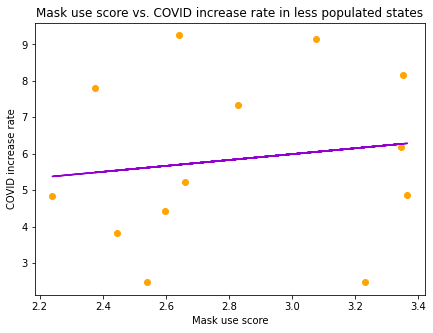

In [37]:
x=low_density_states['mask_use_score']
y=low_density_states['total_increase_rate']
m, b = np.polyfit(x, y, 1)  #m = slope, b=intercept
plt.figure(figsize=(7,5))
plt.plot(x, m*x+b, color='darkviolet')

plt.scatter(low_density_states[['mask_use_score']],low_density_states[['total_increase_rate']],color='orange')
plt.title("Mask use score vs. COVID increase rate in less populated states")
plt.ylabel('COVID increase rate')
plt.xlabel('Mask use score')
plt.show()


By looking at the scatterplot, there is a positive correlation overall, but because there is no obvious trend and datapoints are far from the regression line, we know the mask use score is not a good indication of the total increase rate in less populated states. 

Now let's check the states with high population density (greater than 221 people per square miles)

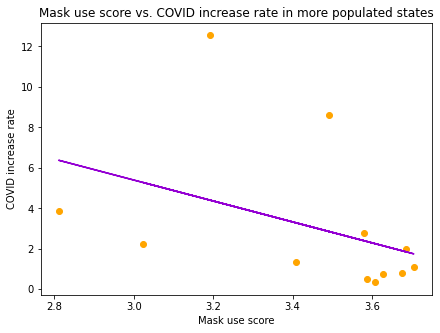

In [38]:
x=high_density_states['mask_use_score']
y=high_density_states['total_increase_rate']
m, b = np.polyfit(x, y, 1)  #m = slope, b=intercept
plt.figure(figsize=(7,5))
plt.plot(x, m*x+b, color='darkviolet')

plt.scatter(high_density_states[['mask_use_score']],high_density_states[['total_increase_rate']],color='orange')
plt.title("Mask use score vs. COVID increase rate in more populated states")
plt.ylabel('COVID increase rate')
plt.xlabel('Mask use score')
plt.show()

Even though the datapoints are also very scattered, we have see an obvious trend, the negative correlation between mask_use_score and covid increase rate is more obvious in high populated states.

Lastly, let's observe a heatmap for the correlation between mask use score, four case increase rates, and population density.  


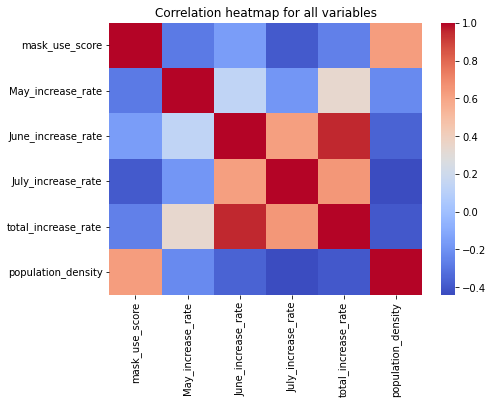

In [39]:
corr = total_df.corr() # train is a pandas dataframe 
plt.figure(figsize = (7, 5))
heatmap(corr, cmap = 'coolwarm')
plt.title('Correlation heatmap for all variables')
plt.show()

From the heatmap shown above, we actually find the mask use score is mostly correlated with the state's population density, then it's the July's case increase rate, and lastly it's the overall increase rate. This make sense because the survey was conducted in July, the mask-use-score is more accurate for July. Maybe we can do another research about the how does mask score related to population density in the future. We also observed that the total increase rate is largely correlated to June and July's data, one possible explanation could be that June has the most signicate increase rate.

### 3. Conclusion and future improvement

Through this analysis, we cannot determine if there is any linear relationship between using face-mask and chance of getting covid. Because the coefficient of determination (R square) is low in our least square model, there is not signiciant correlation between our independent varibale- mask use score, and the depdent variable- increase rate of COVID cases from May to July 2020. However, we do see an overall negative correlation between mask-use rate and Covid cases' increase rate in our plots, and the trend become more obvious when states are more populated.

There could many possible reasons of why there is no a signicant correlation. For example, during the summer season June to July, people may going out more which cause the increase rate to went up, or the survey may not be a good representation of how well people are actually using mask, or people may not wear mask properly by following the CDC guidelines.

There are many other factors could affect on the COVID cases' growth rate, and generalizing our data to state-level could cause error. If I were to conduct this research analysis again and trying to improve it, I will look the data in county-level, such as separate the highest populated cities and lowest populated cities, and run the regression analysis to see the impact. I will also consider some major event happening date, such as a new variance has been found, or when some states have enforced different mask policies.